In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 5
FOLDS = [1,2,3,4,5]
PATH = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/' # Main path
DATA_PATH = PATH + 'dataset/' # Data folder
TRAIN_PATH = DATA_PATH + 'train_images/'# Training images folder
ENCODER_NAME = "resnet18"
ANGLE = 180 
S2 = 64
PATCH_H = 512
PATCH_W = 512
BS = 16
LR = 2.5e-4
EPOCHS = 1
TH = .5

In [3]:
S2 = torch.as_tensor(S2)
A = -1/(2*S2).to(device)

In [4]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train_split.csv'))
train.tail()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,5.0
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,5.0
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,5.0
1974,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0


In [5]:
df_coor = pd.read_csv(os.path.join(DATA_PATH, 'train_label_coordinates.csv'))
df_coor.tail()

,study_id,series_id,instance_number,condition,level,x,y
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333
48691,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L5/S1,211.813953,259.534884


In [6]:
F = df_coor[
    df_coor['condition'].isin([
        'Left Neural Foraminal Narrowing',
        'Right Neural Foraminal Narrowing'
    ])
].drop(columns=['condition']).sort_values([
    'study_id',
    'series_id',
    'level'
]).reset_index(drop=True)
F.tail()

,study_id,series_id,instance_number,level,x,y
19714,4290709089,4237840455,12,L3/L4,202.724796,181.013624
19715,4290709089,4237840455,4,L4/L5,208.381925,222.922987
19716,4290709089,4237840455,12,L4/L5,202.933333,219.733333
19717,4290709089,4237840455,4,L5/S1,215.268102,261.657732
19718,4290709089,4237840455,12,L5/S1,211.813953,259.534884


In [7]:
coordinates = {}
for i in range(len(F)):
    row = F.iloc[i]
    coordinates[row['study_id']] = {}
for i in range(len(F)):
    row = F.iloc[i]
    coordinates[row['study_id']][row['series_id']] = {}
for i in range(len(F)):
    row = F.iloc[i]
    coordinates[row['study_id']][row['series_id']][row['instance_number']] = {
        'L1/L2':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L2/L3':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L3/L4':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L4/L5':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L5/S1':{
            'x':torch.nan,
            'y':torch.nan
        }
    }
for i in range(len(F)):
    row = F.iloc[i]
    coordinates[row['study_id']][row['series_id']][row['instance_number']][row['level']]['x'] = row['x']
    coordinates[row['study_id']][row['series_id']][row['instance_number']][row['level']]['y'] = row['y']

In [8]:
F =  F[[
    'study_id',
    'series_id',
    'instance_number'
]].groupby([
    'study_id',
    'series_id',
    'instance_number'
]).count().reset_index()
F.tail()

,study_id,series_id,instance_number
8277,4287160193,327893304,12
8278,4290709089,4237840455,4
8279,4290709089,4237840455,5
8280,4290709089,4237840455,11
8281,4290709089,4237840455,12


In [9]:
v = np.zeros((len(F),10))
for i in tqdm(range(len(F))):
    row = F.iloc[i]
    k = 0
    for level in coordinates[row['study_id']][row['series_id']][row['instance_number']]:
        v[i,k:k+2] = list(coordinates[row['study_id']][row['series_id']][row['instance_number']][level].values())
        k += 2

100%|██████████| 8282/8282 [00:00<00:00, 8491.98it/s]


In [10]:
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'    
]

In [11]:
F[coor] = v
F.tail()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
8277,4287160193,327893304,12,NaN,NaN,NaN,NaN,176.894155,189.590489,182.727708,224.591810,199.256110,260.079260
8278,4290709089,4237840455,4,NaN,NaN,208.106799,140.203404,204.195639,182.791594,208.381925,222.922987,215.268102,261.657732
8279,4290709089,4237840455,5,219.405706,95.459321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8280,4290709089,4237840455,11,219.465940,97.831063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8281,4290709089,4237840455,12,NaN,NaN,205.340599,140.207084,202.724796,181.013624,202.933333,219.733333,211.813953,259.534884


In [12]:
for (study_id,series_id),df in tqdm(F.groupby(['study_id','series_id'])):
    sample = TRAIN_PATH + str(study_id) + '/' + str(series_id)
    instance_numbers = [int(x.replace('\\','/').split('/')[-1].replace('.dcm','')) for x in glob.glob(sample+'/*.dcm')]
    instance_numbers.sort()
    instance_numbers = np.array(instance_numbers)
    D = len(instance_numbers)
    FIRST = int(np.arange(D)[instance_numbers == df['instance_number'].min()])
    LAST = int(np.arange(D)[instance_numbers == df['instance_number'].max()])
    new = instance_numbers[FIRST+1:LAST].tolist()
    if FIRST > 0: new.append(instance_numbers[FIRST - 1])
    if LAST < D - 1: new.append(instance_numbers[LAST + 1])
    L = len(new)
    F = pd.concat([
        F,
        pd.DataFrame({
            'study_id':[int(study_id)]*L,
            'series_id':[int(series_id)]*L,
            'instance_number':new,
            'x_L1L2':[torch.nan]*L,
            'y_L1L2':[torch.nan]*L,
            'x_L2L3':[torch.nan]*L,
            'y_L2L3':[torch.nan]*L,
            'x_L3L4':[torch.nan]*L,
            'y_L3L4':[torch.nan]*L,
            'x_L4L5':[torch.nan]*L,
            'y_L4L5':[torch.nan]*L,
            'x_L5S1':[torch.nan]*L,
            'y_L5S1':[torch.nan]*L
        })
    ])
    

100%|██████████| 1979/1979 [00:02<00:00, 704.18it/s]


In [13]:
F = F.reset_index(drop=True)
F[['study_id','series_id','instance_number']] = F[['study_id','series_id','instance_number']].astype(np.int64)
F.tail()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
27435,4290709089,4237840455,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27436,4290709089,4237840455,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27437,4290709089,4237840455,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27438,4290709089,4237840455,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27439,4290709089,4237840455,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
F_mean = F.groupby(['study_id','series_id']).mean()
F_mean.tail()

,,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
study_id,series_id,,,,,,,,,,,
4282019580,3029774733,11.928571,290.326043,128.454469,266.577092,188.668253,249.400227,249.659136,245.436258,308.409819,252.349276,358.868668
4283570761,2708429184,8.333333,274.188462,177.692184,262.454607,227.049900,251.403867,275.530874,249.926376,319.963923,262.561141,361.475809
4284048608,1875151370,11.937500,222.121287,144.599926,208.473027,194.367397,202.896711,250.237582,197.188796,298.986350,208.375517,344.849449
4287160193,327893304,8.384615,190.034833,111.728635,178.330909,149.032637,176.221250,187.336421,182.114497,225.401787,197.413992,262.627865
4290709089,4237840455,8.000000,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.328160,213.541028,260.596308


In [15]:
F_mean = F_mean.loc[[(study_id,series_id) for study_id,series_id in F[['study_id','series_id']].values]][coor].values
F_mean.shape

(27440, 10)

In [16]:
F_values = F[coor].values
F_values.shape

(27440, 10)

In [17]:
mask = F[coor].isna()
mask.shape

(27440, 10)

In [18]:
F_values[mask] = F_mean[mask]
F[coor] = F_values
F.tail()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
27435,4290709089,4237840455,9,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308
27436,4290709089,4237840455,10,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308
27437,4290709089,4237840455,11,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308
27438,4290709089,4237840455,3,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308
27439,4290709089,4237840455,13,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308


In [19]:
F[F.isna().sum(1) > 0]

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1


In [20]:
df_meta_f = pd.read_csv(os.path.join(DATA_PATH,  'train_series_descriptions.csv'))
df_meta_f.tail()

,study_id,series_id,series_description
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2
6293,4290709089,4237840455,Sagittal T1


In [21]:
F = F.merge(df_meta_f[['series_id','series_description']], left_on='series_id', right_on='series_id')
F.tail()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1,series_description
27435,4290709089,4237840455,9,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1
27436,4290709089,4237840455,10,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1
27437,4290709089,4237840455,11,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1
27438,4290709089,4237840455,3,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1
27439,4290709089,4237840455,13,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1


In [22]:
F.groupby('series_description').count()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
series_description,,,,,,,,,,,,,
Sagittal T1,27440,27440,27440,27440,27440,27440,27440,27440,27440,27440,27440,27440,27440


In [23]:
F = F.merge(train[['study_id','fold']],left_on='study_id',right_on='study_id')
F.tail()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1,series_description,fold
27435,4290709089,4237840455,9,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1,5.0
27436,4290709089,4237840455,10,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1,5.0
27437,4290709089,4237840455,11,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1,5.0
27438,4290709089,4237840455,3,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1,5.0
27439,4290709089,4237840455,13,219.435823,96.645192,206.723699,140.205244,203.460217,181.902609,205.657629,221.32816,213.541028,260.596308,Sagittal T1,5.0


In [24]:
F.groupby('fold').count()

,study_id,series_id,instance_number,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1,series_description
fold,,,,,,,,,,,,,,
1.0,5550,5550,5550,5550,5550,5550,5550,5550,5550,5550,5550,5550,5550,5550
2.0,5489,5489,5489,5489,5489,5489,5489,5489,5489,5489,5489,5489,5489,5489
3.0,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437
4.0,5432,5432,5432,5432,5432,5432,5432,5432,5432,5432,5432,5432,5432,5432
5.0,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532


In [25]:
def augment_image_and_centers(image,centers,center=(PATCH_H/2,PATCH_W/2)):
    # Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-ANGLE, ANGLE))
    image = torchvision.transforms.functional.rotate(
        image,angle.item(),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
        center=center
    )
    # https://discuss.pytorch.org/t/rotation-matrix/128260
    angle = -angle*math.pi/180
    s = torch.sin(angle)
    c = torch.cos(angle)
    rot = torch.stack([
        torch.stack([c, s]),
        torch.stack([-s, c])
    ])
    center = torch.as_tensor(center).float()
    centers = ((centers.cpu() - center) @ rot) + center

    return image,centers

torch_resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

x_map = torch.stack([torch.arange(PATCH_W)]*PATCH_H).float()
y_map = torch.stack([torch.arange(PATCH_H)]*PATCH_W).float()
idx_map = torch.stack([x_map,y_map.T]).view(1,2,PATCH_H,PATCH_W).to(device)

In [26]:
class Sagittal_T1_sagittal_level_Dataset(Dataset):
    def __init__(self, df, VALID=False, alpha=0):
        self.data = df
        self.VALID = VALID
        self.alpha = alpha

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        
        sample = TRAIN_PATH + str(row['study_id']) + '/' + str(row['series_id']) + '/' + str(row['instance_number']) + '.dcm'
        
        image = pydicom.dcmread(sample).pixel_array
        H,W = image.shape
#       By plane resizing, disortion on the proportions is created
        if H > W:
            d = W
            if not self.VALID:
                h = int((H - d)*(.5 + self.alpha*(.5 - np.random.rand())))
            else:
                h = (H - d)//2
            image = image[h:h+d]
            centers[:,1] -= h
            H = W
        elif H < W:
            d = H
            if not self.VALID:
                w = int((W - d)*(.5 + self.alpha*(.5 - np.random.rand())))
            else:
                w = (W - d)//2
            image = image[:,w:w+d]
            centers[:,0] -= w
            W = H
        image = torch_resize(torch.as_tensor((image/np.max(image)).astype(np.float32)).unsqueeze(0))
        image = image.float().to(device)
        
        centers[:,0] = centers[:,0]*PATCH_W/W
        centers[:,1] = centers[:,1]*PATCH_H/H

        if not self.VALID: image,centers = augment_image_and_centers(image,centers)

        return image,centers

In [27]:
tds = Sagittal_T1_sagittal_level_Dataset(F)

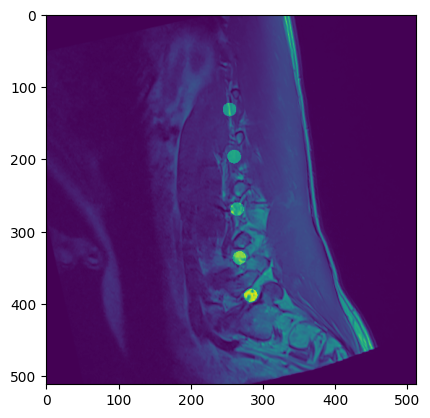

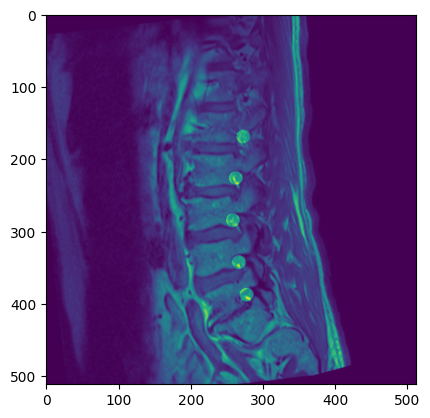

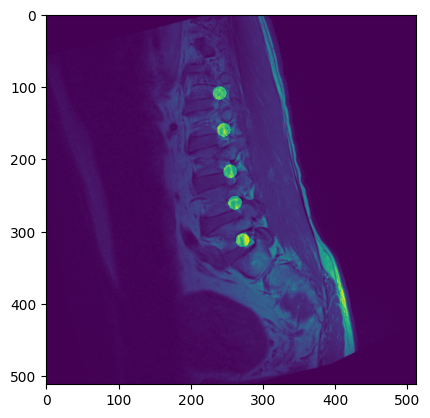

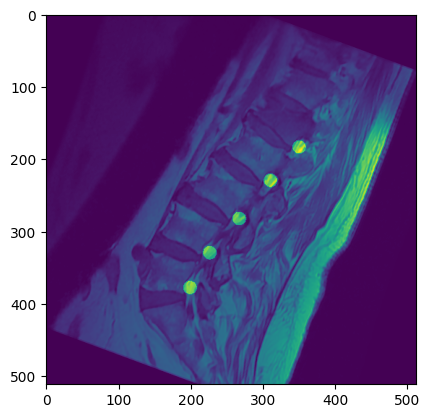

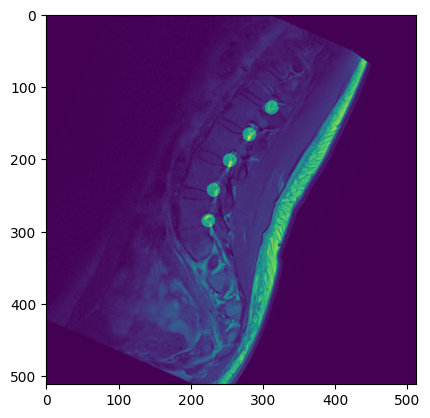

In [28]:
for k in range(5):
    image,centers = tds.__getitem__(np.random.randint(len(tds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    plt.imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [29]:
vds = Sagittal_T1_sagittal_level_Dataset(F,VALID=True)

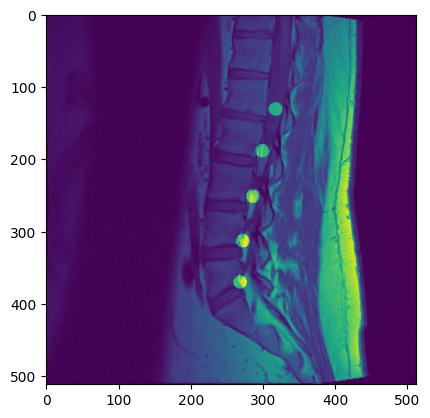

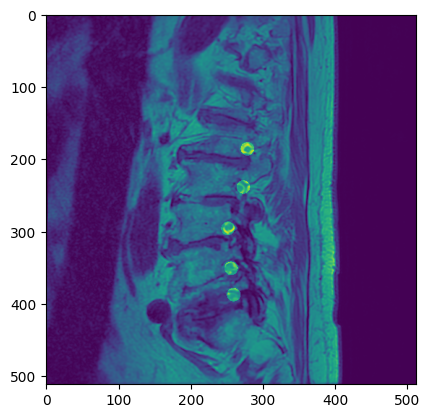

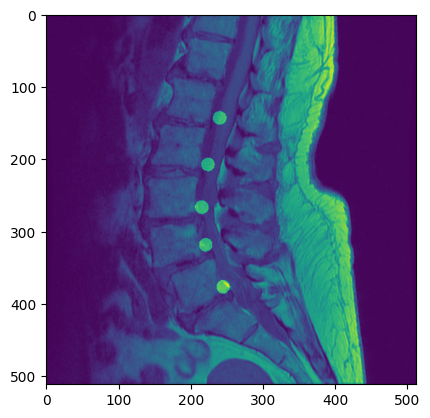

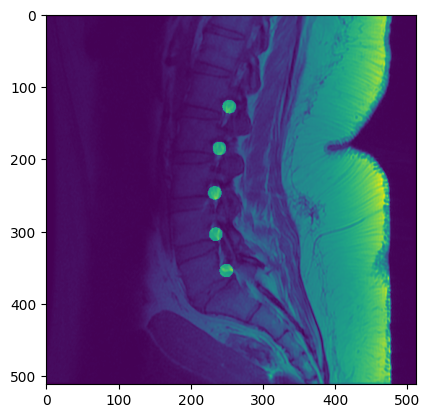

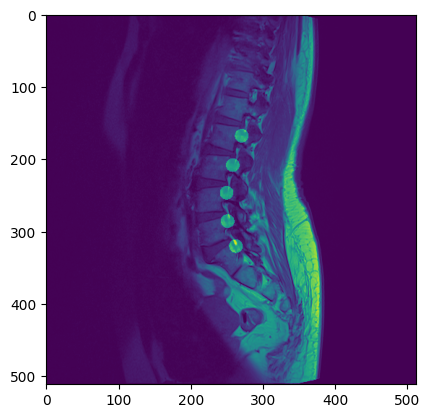

In [30]:
for k in range(5):
    image,centers = vds.__getitem__(np.random.randint(len(vds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    plt.imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [31]:
del tds,vds
gc.collect()

29519

In [32]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [33]:
class myUNet(nn.Module):
    def __init__(
        self,
        classes
        ):
        super(myUNet, self).__init__()

        self.classes = classes
        self.UNet = smp.Unet(
            encoder_name=ENCODER_NAME,
            classes=classes,
            in_channels=1
        ).to(device)

    def forward(self,X):
        H,W = X.shape[-2:]
        x = self.UNet(X.view(-1,1,H,W)).view(-1,H*W)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.min(-1)[0].view(-1,1)
        max_values = x.max(-1)[0].view(-1,1)
        d = (max_values - min_values)
        d[d == 0] = 1
        x = (x - min_values)/d
        
        return x.view(-1,self.classes,H,W)

In [34]:
class myLoss(nn.Module):
    def __init__(
            self,
            alpha=.5,
            smooth = 1e-6
        ):
        super().__init__()
        self.alpha = alpha
        self.smooth = smooth

    def clone(self):
        return myLoss(self.alpha)

    def forward(
            self,
            heatmaps,# Predictions
            centers # Targets
        ):
        H,W = heatmaps.shape[-2:]
        heatmaps = heatmaps.view(-1,H*W)
        centers = centers.view(-1,2)
        m = centers.isnan().sum(1) == 0
        heatmaps = heatmaps[m]
        centers = centers[m]
#       Ideal heatmaps
        mask = idx_map - centers.view(len(centers),2,1,1).to(device)
        mask = (mask*mask).sum(1)
        mask = torch.exp(A*mask)
        mask = mask.view(-1,H*W)
#       Distance
        D = 1 - ((mask*heatmaps).sum(-1))**2/((mask*mask).sum(-1)*(heatmaps*heatmaps).sum(-1)+self.smooth)
        
        return D.mean()

In [35]:
# CosineAnnealingAlpha
def nt(nmin,nmax,tcur,tmax):
    return (nmax - .5*(nmax-nmin)*(1+np.cos(tcur*np.pi/tmax))).astype(np.float32)

#plt.plot(nt(.25,1,np.arange(EPOCHS),EPOCHS))
#plt.show()

# callback to update alpha during training
def cb(self):
    alpha = torch.as_tensor(nt(.25,1,learn.train_iter,EPOCHS*n_iter))
    learn.dls.train_ds.alpha = alpha
alpha_cb = Callback(before_batch=cb)

epoch,train_loss,valid_loss,time
0,0.204090,0.242162,17:33
1,0.143819,0.141781,20:13


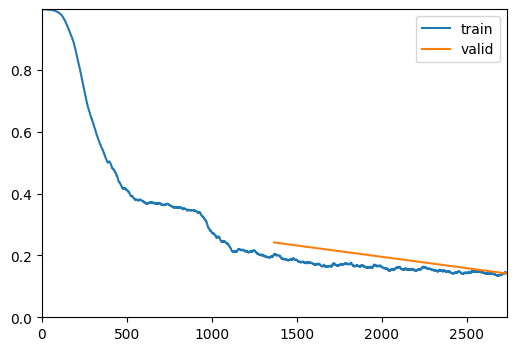

epoch,train_loss,valid_loss,time
0,0.188068,0.229987,19:36
1,0.138526,0.161449,19:22


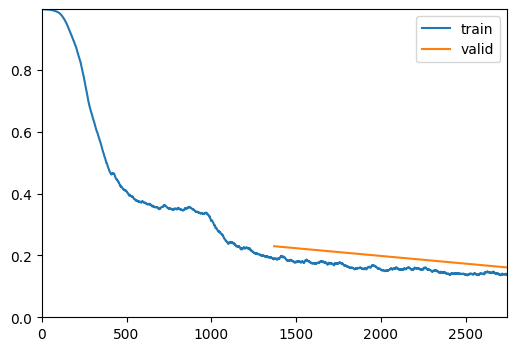

epoch,train_loss,valid_loss,time
0,0.178613,0.173084,18:06
1,0.143515,0.136248,19:30


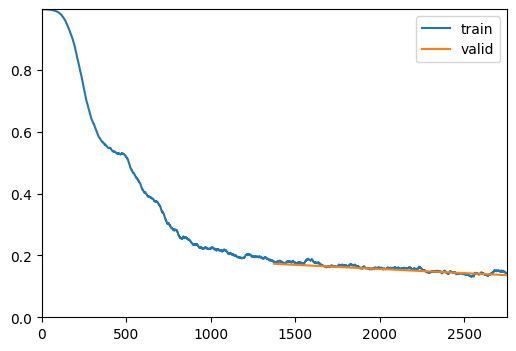

epoch,train_loss,valid_loss,time
0,0.212405,0.209791,18:09
1,0.141822,0.136925,18:04


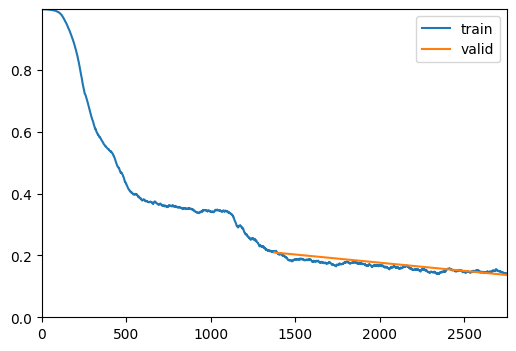

epoch,train_loss,valid_loss,time
0,0.328071,0.330918,18:07
1,0.172924,0.184003,17:58


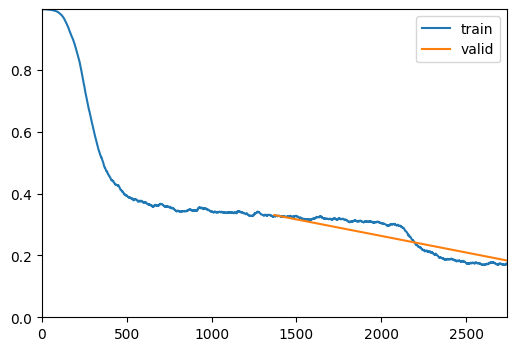

In [36]:
for f in FOLDS:
    seed_everything(SEED)
    model = myUNet(5)
    
    tdf = F[F['fold'] != f]
    vdf = F[F['fold'] == f]

    tds = Sagittal_T1_sagittal_level_Dataset(tdf)
    vds = Sagittal_T1_sagittal_level_Dataset(vdf,VALID=True)
    
    tdl = torch.utils.data.DataLoader(tds, batch_size=BS, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(vds, batch_size=BS, shuffle=False)

    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        lr=LR,
        loss_func=myLoss(alpha=0.5),
        cbs=[
            ShowGraphCallback(),
            alpha_cb
        ]
    )
    learn.fit_one_cycle(EPOCHS)
    torch.save(model,'Sagittal_T1_sagittal_level_segmentation_'+str(f))
    del tdl,vdl,dls,model,learn
    gc.collect()

In [37]:
f = 1
model = torch.load('Sagittal_T1_sagittal_level_segmentation_'+str(f))
vdf = F[F['fold'] == f]
vds = Sagittal_T1_sagittal_level_Dataset(vdf,VALID=True)

3644


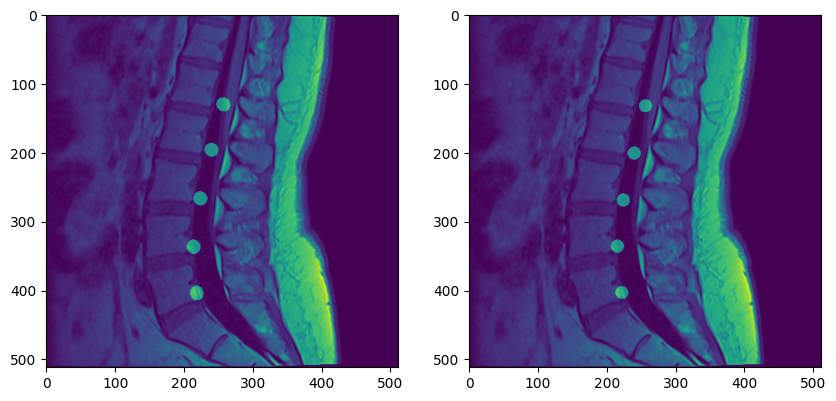

4442


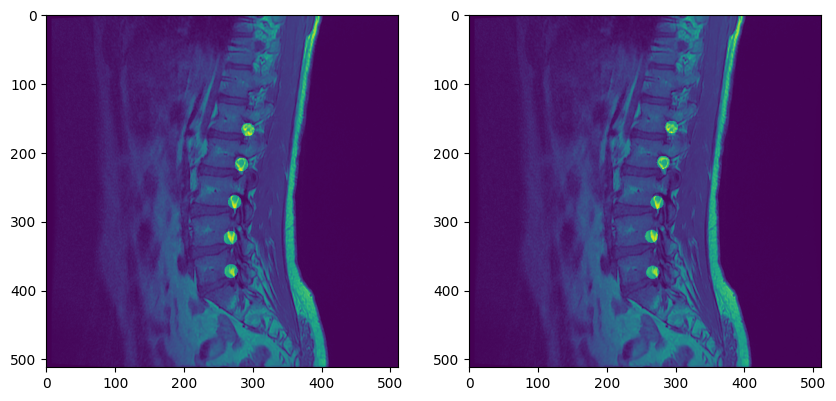

834


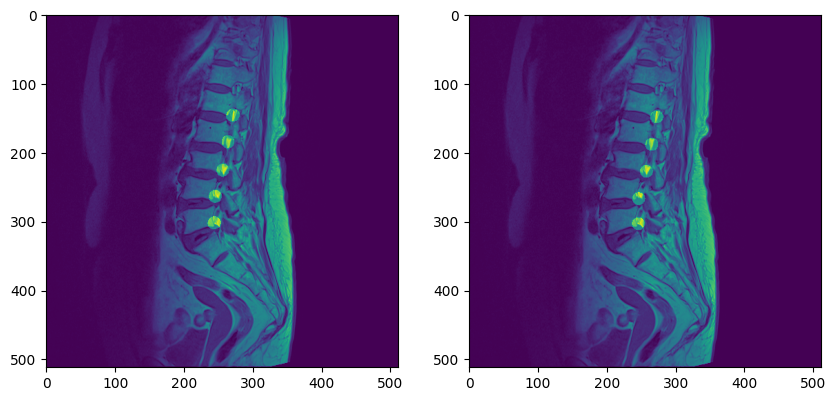

4090


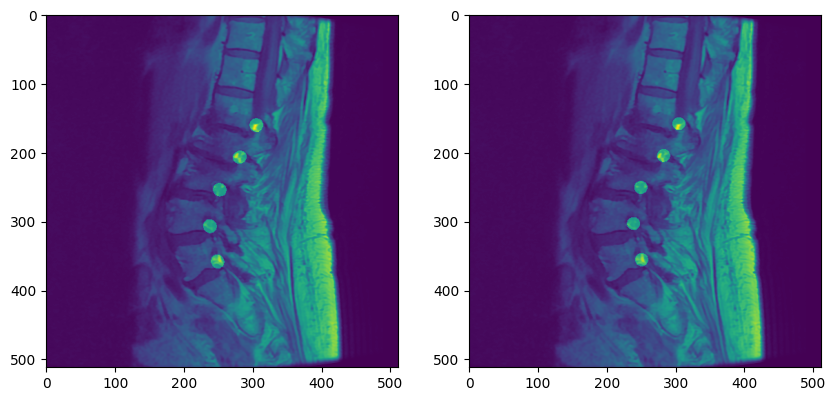

5423


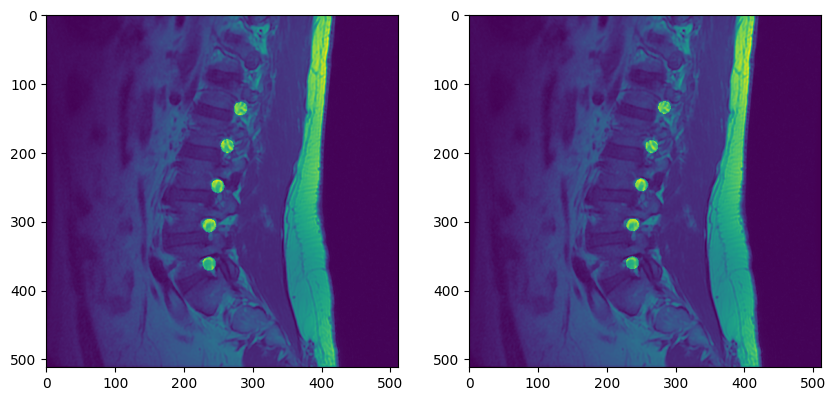

In [38]:
for k in range(5):
    i = np.random.randint(len(vds))
    print(i)
    image,centers = vds.__getitem__(np.random.randint(len(vds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes[0].imshow(image.cpu()[0] + .5*(model(image.unsqueeze(0))[0].detach().cpu() > TH).sum(0))
    axes[1].imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [39]:
del model,vdf,vds
gc.collect()

35339